# Домашняя работа по дисциплине "Классическое машинное обучение" 

## Практическое задание №3

Работу выполнил студент Груданов Николай.

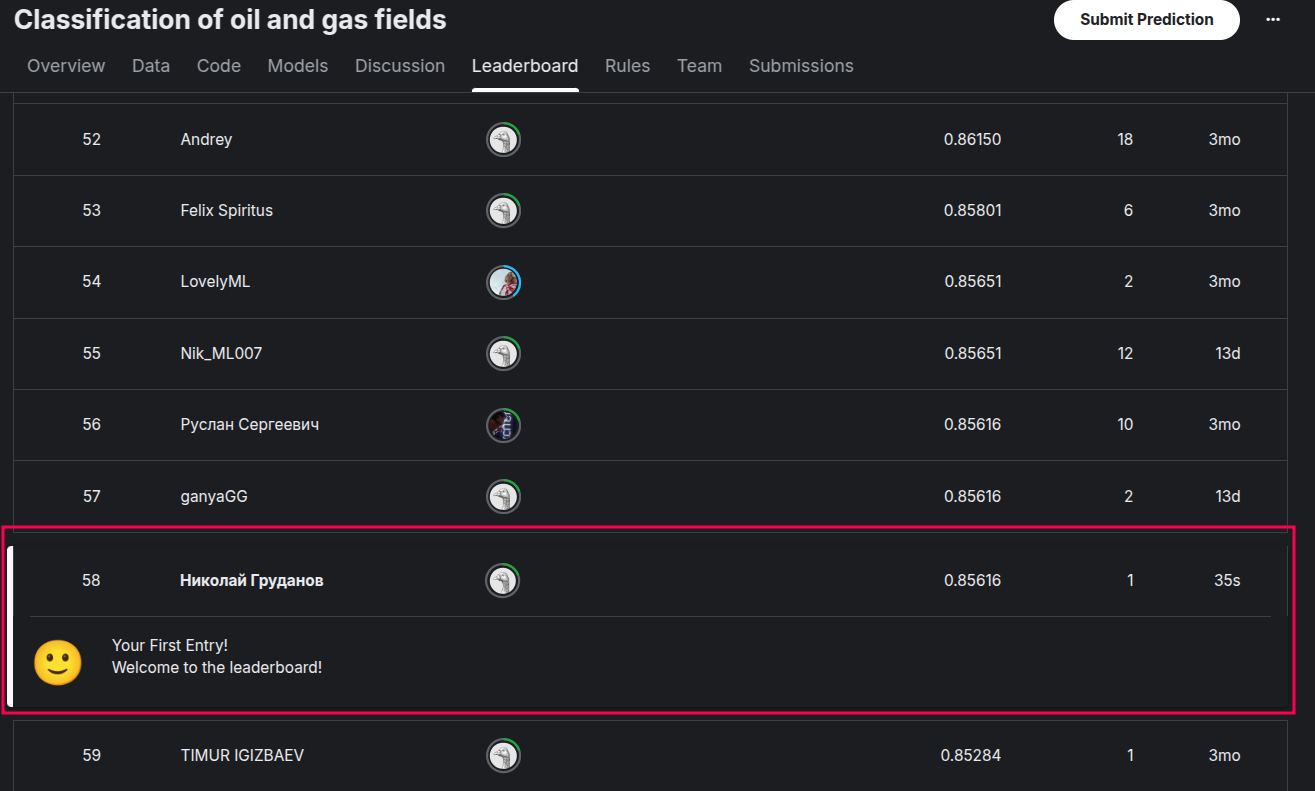

Импорт библиотек

In [17]:
# --- Основные библиотеки для работы с данными ---
import pandas as pd
import numpy as np

# --- Библиотеки для визуализации ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Модули из Scikit-learn для предобработки данных ---
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Модели машинного обучения ---
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# --- Метрики для оценки качества моделей ---
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Библиотека для балансировки классов ---
from imblearn.over_sampling import SMOTE

# --- Настройки для улучшения отображения ---
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


Загрузка и первичный анализ данных

In [18]:
# Загружаем данные
train_df = pd.read_csv('./classification-of-oil-and-gas-fields/train_oil.csv')
test_df = pd.read_csv('./classification-of-oil-and-gas-fields/oil_test.csv')

In [19]:
print(f"Размер тренировочного набора: {train_df.shape}")
print(f"Размер тестового набора: {test_df.shape}")

Размер тренировочного набора: (309, 20)
Размер тестового набора: (133, 19)


In [20]:
train_df.head()

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Reservoir period,Lithology,Thickness (gross average ft),Thickness (net pay average ft),Porosity,Permeability
0,ZHIRNOV,MELEKESKIAN,RUSSIA,FORMER SOVIET UNION,VOLGA-URAL,COMPRESSION/EVAPORITE,51.0000,44.8042,NIZHNEVOLZHSKNET,ONSHORE,OIL,DECLINING PRODUCTION,FORELAND,1870,CARBONIFEROUS,SANDSTONE,262.0,33.0,24.0,30.0
1,LAGOA PARDA,LAGOA PARDA (URUCUTUCA),BRAZIL,LATIN AMERICA,ESPIRITO SANTO,EXTENSION,-19.6017,-39.8332,PETROBRAS,ONSHORE,OIL,NEARLY DEPLETED,PASSIVE MARGIN,4843,PALEOGENE,SANDSTONE,2133.0,72.0,23.0,350.0
2,ABQAIQ,ARAB D,SAUDI ARABIA,MIDDLE EAST,THE GULF,COMPRESSION/EVAPORITE,26.0800,49.8100,SAUDI ARAMCO,ONSHORE,OIL,REJUVENATING,FORELAND,6050,JURASSIC,LIMESTONE,250.0,184.0,21.0,410.0
3,MURCHISON,BRENT,UK /NORWAY,EUROPE,NORTH SEA NORTHERN,EXTENSION,61.3833,1.7500,CNR,OFFSHORE,OIL,NEARLY DEPLETED,RIFT,8988,JURASSIC,SANDSTONE,425.0,300.0,22.0,750.0
4,WEST PEMBINA,NISKU (PEMBINA L POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,53.2287,-115.8008,NUMEROUS,ONSHORE,OIL,UNKNOWN,FORELAND,9306,DEVONIAN,DOLOMITE,233.0,167.0,11.8,1407.0


In [21]:
print("Тренировочный датасет:")
train_df.info()
print("\n" + "="*50 + "\n")
print("Тестовый датасет:")
test_df.info()

Тренировочный датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural se

In [22]:
print("\nРаспределение целевой переменной 'Onshore/Offshore':")
print(train_df['Onshore/Offshore'].value_counts())


Распределение целевой переменной 'Onshore/Offshore':
Onshore/Offshore
ONSHORE             218
OFFSHORE             86
ONSHORE-OFFSHORE      5
Name: count, dtype: int64


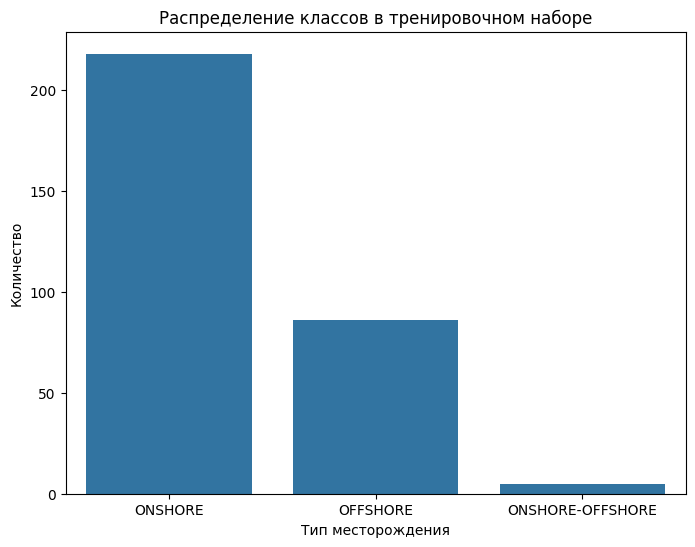

In [23]:
# Визуализация распределения классов
plt.figure(figsize=(8, 6))
sns.countplot(x='Onshore/Offshore', data=train_df)
plt.title('Распределение классов в тренировочном наборе')
plt.xlabel('Тип месторождения')
plt.ylabel('Количество')
plt.show()

Предобработка данных и Feature Engineering

In [24]:
# --- 1. Обработка целевой переменной ---
# Класс 'ONSHORE-OFFSHORE' встречается очень редко, объединим его с 'ONSHORE'
train_df['Onshore/Offshore'] = train_df['Onshore/Offshore'].replace('ONSHORE-OFFSHORE', 'ONSHORE')
# Преобразуем в числовой формат: ONSHORE = 1, OFFSHORE = 0
train_df['Onshore/Offshore'] = train_df['Onshore/Offshore'].map({'ONSHORE': 1, 'OFFSHORE': 0})
print("\n" + "="*50 + "\n")
print("Распределение целевой переменной после преобразования:")
print(train_df['Onshore/Offshore'].value_counts())




Распределение целевой переменной после преобразования:
Onshore/Offshore
1    223
0     86
Name: count, dtype: int64


In [25]:
# --- 2. Определим типы признаков ---
target: str = 'Onshore/Offshore'
features_to_drop: list[str] = ['Field name', 'Reservoir unit', 'Operator company']

categorical_features: list[str] = [
    col for col in train_df.columns
    if train_df[col].dtype == 'object' and col not in features_to_drop
]
numerical_features: list[str] = [
    col for col in train_df.columns
    if train_df[col].dtype != 'object' and col != target
]
# --- 3. Удаление ненужных столбцов ---
train_df_processed = train_df.drop(columns=features_to_drop)
test_df_processed = test_df.drop(columns=features_to_drop)


print(f"Список категориальных признаков: {categorical_features}")
print(f"Список числовых признаков: {numerical_features}")
print(f"Список столбцов для удаления: {features_to_drop}")



Список категориальных признаков: ['Country', 'Region', 'Basin name', 'Tectonic regime', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Reservoir period', 'Lithology']
Список числовых признаков: ['Latitude', 'Longitude', 'Depth', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability']
Список столбцов для удаления: ['Field name', 'Reservoir unit', 'Operator company']


In [26]:
# --- 4. Заполнение пропусков ---
# Для числовых признаков используем медиану
for col in numerical_features:
    median_val = train_df_processed[col].median()
    train_df_processed[col].fillna(median_val, inplace=True)
    test_df_processed[col].fillna(median_val, inplace=True)

# Для категориальных - значение 'Unknown'
for col in categorical_features:
    train_df_processed[col].fillna('Unknown', inplace=True)
    test_df_processed[col].fillna('Unknown', inplace=True)

print("\nРазмер обработанного тренировочного набора:", train_df_processed.shape)
print("Размер обработанного тестового набора:", test_df_processed.shape)
print("Размер тестового набора:", len(test_df_processed))
print("Размер тренировочного набора:", len(train_df_processed))


Размер обработанного тренировочного набора: (309, 17)
Размер обработанного тестового набора: (133, 16)
Размер тестового набора: 133
Размер тренировочного набора: 309


In [27]:
# --- 5. Feature Engineering (Создание новых признаков) ---
def create_features(df):
    df['Net_to_Gross_Ratio'] = df['Thickness (net pay average ft)'] / df['Thickness (gross average ft)']
    df['Porosity_Permeability'] = df['Porosity'] * df['Permeability']
    # Заменяем бесконечные значения, которые могли появиться из-за деления на 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    return df

train_df_processed = create_features(train_df_processed)
test_df_processed = create_features(test_df_processed)

# Обновляем список числовых признаков
numerical_features.extend(['Net_to_Gross_Ratio', 'Porosity_Permeability'])
print(f"Обновленный список числовых признаков: {numerical_features}")


Обновленный список числовых признаков: ['Latitude', 'Longitude', 'Depth', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability', 'Net_to_Gross_Ratio', 'Porosity_Permeability']


In [28]:
# --- 6. Кодирование категориальных признаков ---
# Используем LabelEncoder, так как он прост и эффективен для древовидных моделей
for col in categorical_features:
    le = LabelEncoder()
    # Объединяем категории из train и test, чтобы кодировщик знал обо всех возможных значениях
    all_categories = pd.concat([train_df_processed[col], test_df_processed[col]], axis=0).unique()
    le.fit(all_categories)
    train_df_processed[col] = le.transform(train_df_processed[col])
    test_df_processed[col] = le.transform(test_df_processed[col])

# --- 7. Масштабирование числовых признаков ---
scaler = StandardScaler()
train_df_processed[numerical_features] = scaler.fit_transform(train_df_processed[numerical_features])
test_df_processed[numerical_features] = scaler.transform(test_df_processed[numerical_features])

print("Размер обработанного тренировочного набора:", train_df_processed.shape)
print("Размер обработанного тестового набора:", test_df_processed.shape)
print("Размер тестового набора:", len(test_df_processed))
print("Размер тренировочного набора:", len(train_df_processed))


Размер обработанного тренировочного набора: (309, 19)
Размер обработанного тестового набора: (133, 18)
Размер тестового набора: 133
Размер тренировочного набора: 309


Разделение данных и балансировка классов

In [29]:
# Разделение данных на признаки (X) и цель (y)
X = train_df_processed.drop(columns=[target])
y = train_df_processed[target]

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки до SMOTE: {X_train.shape}")
print(f"Распределение классов в y_train до SMOTE:\n{y_train.value_counts()}")

# Применение SMOTE для балансировки
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\nРазмер обучающей выборки после SMOTE: {X_train_resampled.shape}")
print(f"Распределение классов в y_train после SMOTE:\n{y_train_resampled.value_counts()}")


Размер обучающей выборки до SMOTE: (247, 18)
Распределение классов в y_train до SMOTE:
Onshore/Offshore
1    178
0     69
Name: count, dtype: int64

Размер обучающей выборки после SMOTE: (356, 18)
Распределение классов в y_train после SMOTE:
Onshore/Offshore
1    178
0    178
Name: count, dtype: int64


Обучение и сравнение моделей

Обучим несколько популярных моделей классификации и сравним их производительность на валидационной выборке.

In [30]:
# Список моделей для тестирования
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Обучение и оценка каждой модели
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    print(f"--- {name} ---")
    print(f"F1-score на валидационной выборке: {f1:.4f}")
    print(classification_report(y_val, y_pred))
    print("-" * 30 + "\n")


--- Logistic Regression ---
F1-score на валидационной выборке: 0.7921
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.86      0.84      0.85        45

    accuracy                           0.79        62
   macro avg       0.74      0.75      0.74        62
weighted avg       0.79      0.79      0.79        62

------------------------------

--- K-Nearest Neighbors ---
F1-score на валидационной выборке: 0.8121
              precision    recall  f1-score   support

           0       0.62      0.76      0.68        17
           1       0.90      0.82      0.86        45

    accuracy                           0.81        62
   macro avg       0.76      0.79      0.77        62
weighted avg       0.82      0.81      0.81        62

------------------------------

--- Random Forest ---
F1-score на валидационной выборке: 0.8414
              precision    recall  f1-score   support

           0       0.68

Подбор гиперпараметров для лучшей модели

In [31]:
# Задаем сетку параметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Инициализируем поиск по сетке с кросс-валидацией
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3 фолда для кросс-валидации
    scoring='f1_weighted',
    n_jobs=-1, # Использовать все доступные ядра процессора
    verbose=1
)

# Запускаем поиск на сбалансированных данных
grid_search.fit(X_train_resampled, y_train_resampled)

# Выводим лучшие параметры и лучший F1-score
print(f"Лучшие параметры для Random Forest: {grid_search.best_params_}")
print(f"Лучший F1-score (на кросс-валидации): {grid_search.best_score_:.4f}")

# Оцениваем лучшую модель на валидационной выборке
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)
print("\nОтчет по классификации для лучшей модели на валидационной выборке:")
print(classification_report(y_val, y_pred_best))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры для Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Лучший F1-score (на кросс-валидации): 0.9326

Отчет по классификации для лучшей модели на валидационной выборке:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.91      0.91      0.91        45

    accuracy                           0.87        62
   macro avg       0.84      0.84      0.84        62
weighted avg       0.87      0.87      0.87        62



Создание файла для Kaggle

Теперь, когда у нас есть настроенная модель, используем ее для предсказания на тестовых данных и формируем файл для отправки.

In [32]:
# Делаем предсказания на обработанных тестовых данных
test_predictions = best_model.predict(test_df_processed)

# Создаем DataFrame для отправки
submission_df = pd.DataFrame({
    'index': test_df.index,  # Используем индекс из оригинального датасета test_df
    'Onshore/Offshore': test_predictions # Оставляем числовые предсказания (0 или 1)
})

# Сохраняем в CSV файл.
submission_df.to_csv('submission.csv', index=False)

print("Файл 'submission.csv' успешно создан и готов к отправке на Kaggle!\n")
print("Пример содержимого файла:\n")
print(submission_df.head())


Файл 'submission.csv' успешно создан и готов к отправке на Kaggle!

Пример содержимого файла:

   index  Onshore/Offshore
0      0                 1
1      1                 0
2      2                 1
3      3                 0
4      4                 1
